<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

참고, todo

참고. tensorflow, pathlib, 딥러닝 기본(optimizer, loss)

[todo] - 길이 시각화, 세션 개념

- Evaluation 으로 사용하는 함수 (recall, MRR) mAP
- Session Based Task 이해
- Train/Valid/Test 전략
- Session-Parrarel Mini-Batch 를 왜 썼는지 -> 사실 요즘 논문에서는 거의 안쓴다.대신 데이터 특징을 살린 모델링.
- (참고) loss, sampling 제외
- 라벨을 자체적으로 구축

- [recsys 2015 challenge](https://recsys.yoochoose.net/challenge.html) dataset
- (참고) 7z 확장자로 압축되어 있음. 다운로드 및 압축푸는 과정은 생략함.

- ![aladin](./asset/시크릿모드.png)

>The YOOCHOOSE dataset contain a collection of sessions from a retailer, where each session
is encapsulating the click events that the user performed in the session.
For some of the sessions, there are also buy events; means that the session ended
with the user bought something from the web shop. The data was collected during several
months in the year of 2014, reflecting the clicks and purchases performed by the users
of an on-line retailer in Europe.  **To protect end users privacy, as well as the retailer,
all numbers have been modified.** Do not try to reveal the identity of the retailer.

In [1]:
import datetime as dt
from pathlib import Path

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [2]:
data_path = Path('/Users/zimin/Downloads/archive/')  # 'D:\\data\\yoochoose-data\\'

In [3]:
def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path / 'yoochoose-clicks.dat', sep=',', header=None, usecols=[0, 1, 2],
                       parse_dates=[1], dtype={0: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['SessionId', 'Time', 'ItemId']
    return data

In [4]:
data = load_data(data_path, None)
data

,SessionId,Time,ItemId
0,1,2014-04-07 10:51:09.277000+00:00,214536502
1,1,2014-04-07 10:54:09.868000+00:00,214536500
2,1,2014-04-07 10:54:46.998000+00:00,214536506
3,1,2014-04-07 10:57:00.306000+00:00,214577561
4,2,2014-04-07 13:56:37.614000+00:00,214662742
...,...,...,...
33003939,11299809,2014-09-25 09:33:22.412000+00:00,214819412
33003940,11299809,2014-09-25 09:43:52.821000+00:00,214830939
33003941,11299811,2014-09-24 19:02:09.741000+00:00,214854855
33003942,11299811,2014-09-24 19:02:11.894000+00:00,214854838


In [134]:
data['SessionId'].nunique(), data['ItemId'].nunique()

(7981360, 37298)

In [5]:
session_length = data.groupby('SessionId').size()

In [7]:
session_length.median()

2.0

In [8]:
session_length.mean()

3.568098481587947

In [9]:
session_length.max()

200

In [14]:
session_length.quantile(0.99)

18.0

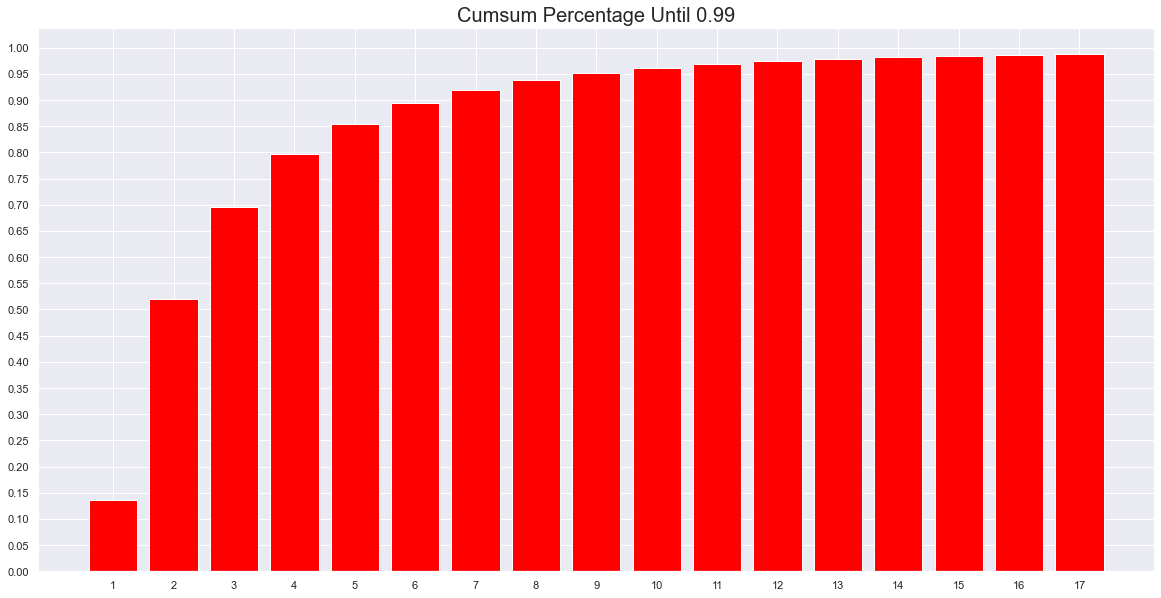

In [89]:
length_count = session_length.groupby(session_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_99 = length_percent_cumsum[length_percent_cumsum<0.99]

import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plt.bar(x=length_percent_cumsum_99.index,
        height=length_percent_cumsum_99, color='red')
plt.xticks(length_percent_cumsum_99.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.99', size=20)
plt.show()

In [137]:
oldest, latest = data['Time'].min(), data['Time'].max()
print(oldest) 
print(latest)

2014-04-01 03:00:00.124000+00:00
2014-09-30 02:59:59.430000+00:00


- 공부를 위해 일단 1달치만 사용. 달을 늘리면 성능이 좋아질까요?

In [140]:
month_ago = latest - dt.timedelta(30)
data = data[data['Time'] > month_ago]

In [141]:
data

,SessionId,Time,ItemId
0,1,2014-04-07 10:51:09.277000+00:00,214536502
1,1,2014-04-07 10:54:09.868000+00:00,214536500
2,1,2014-04-07 10:54:46.998000+00:00,214536506
3,1,2014-04-07 10:57:00.306000+00:00,214577561
4,2,2014-04-07 13:56:37.614000+00:00,214662742
...,...,...,...
28055035,9737846,2014-08-29 19:43:41.969000+00:00,214845973
28055036,9737841,2014-08-27 18:52:14.222000+00:00,214550383
28055037,9737841,2014-08-27 18:56:00.924000+00:00,214581815
28055042,9737842,2014-08-28 09:31:11.704000+00:00,214746401


In [90]:
def cleanse_recursive(data: pd.DataFrame, shortest=2, least_click=5) -> pd.DataFrame:
    while True:
        before_len = len(data)
        data = cleanse_short_session(data, shortest)
        data = cleanse_unpopular_item(data, least_click)
        after_len = len(data)
        if before_len == after_len:
            break
    return data


def cleanse_short_session(data: pd.DataFrame, shortest=2):
    session_len = data.groupby('SessionId').size()
    session_use = session_len[session_len >= shortest].index
    data = data[data['SessionId'].isin(session_use)]
    return data


def cleanse_unpopular_item(data: pd.DataFrame, least_click=5):
    item_popular = data.groupby('ItemId').size()
    item_use = item_popular[item_popular >= least_click].index
    data = data[data['ItemId'].isin(item_use)]
    return data

In [91]:
data = cleanse_recursive(data)
data

,SessionId,Time,ItemId
0,1,2014-04-07 10:51:09.277000+00:00,214536502
1,1,2014-04-07 10:54:09.868000+00:00,214536500
2,1,2014-04-07 10:54:46.998000+00:00,214536506
3,1,2014-04-07 10:57:00.306000+00:00,214577561
4,2,2014-04-07 13:56:37.614000+00:00,214662742
...,...,...,...
33003939,11299809,2014-09-25 09:33:22.412000+00:00,214819412
33003940,11299809,2014-09-25 09:43:52.821000+00:00,214830939
33003941,11299811,2014-09-24 19:02:09.741000+00:00,214854855
33003942,11299811,2014-09-24 19:02:11.894000+00:00,214854838


In [92]:
def split_by_date(data: pd.DataFrame, n_days: int):
    final_time = data['Time'].max()
    session_last_time = data.groupby('SessionId')['Time'].max()
    session_in_train = session_last_time[session_last_time < final_time - dt.timedelta(n_days)].index
    session_in_test = session_last_time[session_last_time >= final_time - dt.timedelta(n_days)].index

    before_date = data[data['SessionId'].isin(session_in_train)]
    after_date = data[data['SessionId'].isin(session_in_test)]
    after_date = after_date[after_date['ItemId'].isin(before_date['ItemId'])]
    return before_date, after_date

In [93]:
tr, test = split_by_date(data, n_days=1)
test = cleanse_short_session(test)

In [94]:
tr, val = split_by_date(tr, n_days=1)
val = cleanse_short_session(val)

In [106]:
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Sessions: {data["SessionId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Time"].min()}\n'
          f'\t Last Time : {data["Time"].max()}\n')

In [107]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 31578159
	 Sessions: 7953665
	 Items: 37295
	 First Time : 2014-04-01 03:00:00.124000+00:00
	 Last Time : 2014-09-28 02:57:34.348000+00:00

* valid Set Stats Info
	 Events: 58233
	 Sessions: 12372
	 Items: 6359
	 First Time : 2014-09-28 03:00:25.298000+00:00
	 Last Time : 2014-09-29 02:58:27.660000+00:00

* test Set Stats Info
	 Events: 71219
	 Sessions: 15323
	 Items: 6749
	 First Time : 2014-09-29 02:37:20.695000+00:00
	 Last Time : 2014-09-30 02:59:59.430000+00:00



In [97]:
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

In [98]:
tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

In [99]:
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data, session_key='SessionId', item_key='ItemId', time_key='Time'):
        self.df = data
        self.session_key = session_key
        self.item_key = item_key
        self.time_key = time_key
        self.idx2id = self.get_vocab()
        self.df['item_idx'] = self.df['ItemId'].map(self.idx2id.get)

        self.df.sort_values([session_key, time_key], inplace=True)
        self.click_offsets = self.get_click_offsets()
        self.session_idx_arr = np.arange(self.df[self.session_key].nunique())  # indexing to SessionId

    def get_vocab(self):
        return {index: item_id for item_id, index in enumerate(self.df['ItemId'].unique())}

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df[self.session_key].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby(self.session_key).size().cumsum()
        return offsets

In [100]:
tr_dataset = SessionDataset(tr)
tr_dataset.click_offsets

array([       0,        4,       10, ..., 31578154, 31578156, 31578159],
      dtype=int32)

In [101]:
tr_dataset.session_idx_arr

array([      0,       1,       2, ..., 7953662, 7953663, 7953664])

In [102]:
tr_dataset.df.head(10)

,SessionId,Time,ItemId,item_idx
0,1,2014-04-07 10:51:09.277000+00:00,214536502,0
1,1,2014-04-07 10:54:09.868000+00:00,214536500,1
2,1,2014-04-07 10:54:46.998000+00:00,214536506,2
3,1,2014-04-07 10:57:00.306000+00:00,214577561,3
4,2,2014-04-07 13:56:37.614000+00:00,214662742,4
5,2,2014-04-07 13:57:19.373000+00:00,214662742,4
6,2,2014-04-07 13:58:37.446000+00:00,214825110,5
7,2,2014-04-07 13:59:50.710000+00:00,214757390,6
8,2,2014-04-07 14:00:38.247000+00:00,214757407,7
9,2,2014-04-07 14:02:36.889000+00:00,214551617,8


[iter 설명](https://dojang.io/mod/page/view.php?id=2405)

In [103]:
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)
        last_session = first_iters[-1]
        start = self.dataset.click_offsets[self.dataset.session_idx_arr[first_iters]]
        end = self.dataset.click_offsets[self.dataset.session_idx_arr[first_iters] + 1]
        mask = []
        finished = False
        return start, end, mask, last_session, finished

    def update_status(self, start, end, min_len, last_session, finished):
        start += min_len
        mask = np.arange(self.batch_size)[(end - start) == 1]

        for i, idx in enumerate(mask, start=1):
            new_session = last_session + i
            if new_session > self.dataset.session_idx_arr[-1]:
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx_arr[new_session]]
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx_arr[new_session] + 1]

        last_session += len(mask)
        return start, end, mask, last_session, finished

In [119]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)
iter_ex = tr_data_loader.__iter__()

tr_dataset.df.head(15)

,SessionId,Time,ItemId,item_idx
0,1,2014-04-07 10:51:09.277000+00:00,214536502,0
1,1,2014-04-07 10:54:09.868000+00:00,214536500,1
2,1,2014-04-07 10:54:46.998000+00:00,214536506,2
3,1,2014-04-07 10:57:00.306000+00:00,214577561,3
4,2,2014-04-07 13:56:37.614000+00:00,214662742,4
5,2,2014-04-07 13:57:19.373000+00:00,214662742,4
6,2,2014-04-07 13:58:37.446000+00:00,214825110,5
7,2,2014-04-07 13:59:50.710000+00:00,214757390,6
8,2,2014-04-07 14:00:38.247000+00:00,214757407,7
9,2,2014-04-07 14:02:36.889000+00:00,214551617,8


- 아래 셀을 반복 실행하면 next가 계속 뱉어냄, input, output, mask를 감잡아 봅시다

In [122]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [ 2  5 16 18]
Label Item Idx are :       [ 3  6 17 18]
Previous Masked Input Idx are [2 3]


- 평가 설명 (mAP, NDCG도 있다)

In [123]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

- 모델 구조가 간단하므로 Funtional 모델

In [124]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

- quiz 구조 바꿔보기, embedding 추가, layer 더 쌓기 등등

In [125]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr))
    model.summary()
    return model

In [126]:
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['SessionId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

args = Args(tr, val, test, batch_size=2048, hsz=50, drop_rate=0.1, lr=0.001, epochs=3, k=20)

In [127]:
model = create_model(args)

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(2048, 1, 37295)]        0         
_________________________________________________________________
GRU (GRU)                    [(2048, 50), (2048, 50)]  5602050   
_________________________________________________________________
dropout (Dropout)            (2048, 50)                0         
_________________________________________________________________
dense (Dense)                (2048, 37295)             1902045   
Total params: 7,504,095
Trainable params: 7,504,095
Non-trainable params: 0
_________________________________________________________________


In [128]:
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['SessionId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for i, (feat, target, mask) in enumerate(tr_loader):
            reset_hidden_states(model, mask)

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            tr_loss = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=tr_loss)

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')
    hidden_states = gru_layer.states[0].numpy()
    for elt in mask:
        hidden_states[elt, :] = 0
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['SessionId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [129]:
train_model(model, args)

Train:   0%|          | 50/11535 [00:48<3:04:45,  1.04it/s, train_loss=9.82]


KeyboardInterrupt: 

quiz. test 셋 평가코드 직접 만들기

In [ ]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

In [ ]:
test_model(model, args, test)